# Прогнозирование оттока клиентов из банка

## Введение

### Описание задачи 

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры. Целевое значение метрики - 0.59. Дополнительно измерим *AUC-ROC* и сравним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### План работ 

1. Подготовка данных.
2. Исследование задачи.
3. Борьба с дисбалансом.
5. Тестирование модели.
5. Исследование AUC-ROC.
6. Общий вывод.

## Подготовка данных

### Обзор данных 

In [1]:
# Как всегда начнём с импортов
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

In [2]:
# Отключим предупреждение о цепном присваивании
pd.options.mode.chained_assignment = None

In [3]:
# Прочитаем csv-файл и выведем датасет на экран
data = pd.read_csv('/datasets/Churn.csv')

data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


На первый взгляд больших проблем в данных не наблюдается. Присутствуют пропуски в столбце `Tenure`.

В датасете присутствуют следующие признаки:
* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата

Целевой признак:
* `Exited` — факт ухода клиента

Колонку RowNumber можно спокойно удалить, т.к. это, вероятнее всего, индекс с исходной базы данных.

### Предобработка 

#### Удаление колонок 

In [5]:
# Удалим колонку RowNumber
# Так же удалим колонки CustomerId и Surname - для модели они не несут пользы, и могут только запутать её
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


#### Заполнение пропусков 

In [6]:
# Взглянем на описательную статистику по датасету
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


В большинстве колонок заметно очень близкие значения среднего и медианы (колонки `CreditScore`, `Age`, `Tenure`, `EstimatedSalary`) - это говорит о том, что выбросов в данных нет или они минимальны. В остальных колонках разброс не настолько большой, чтобы заподозрить проблемы в данных.

В целевом признаке `Exited` среднее значение равно 0,2, в то время как в столбце присутствуют значения равные либо 0, либо 1. Делаем вывод о том, что присутствует дисбаланс классов в целевом признаке.

Пропуски в колонке `Tenure` заполним медианным значением.

In [7]:
data.Tenure = data.Tenure.fillna(data.Tenure.median())
data.Tenure.describe()

count    10000.00000
mean         4.99790
std          2.76001
min          0.00000
25%          3.00000
50%          5.00000
75%          7.00000
max         10.00000
Name: Tenure, dtype: float64

#### Кодирование признаков

In [8]:
# Перекодируем категориальные признаки с помощью прямого кодирования
# В отличии от порядкового кодирования, с прямым кодированием
# у нас будет возможность обучить модель логистической регрессии
data_ohe = pd.get_dummies(data, drop_first=True)

data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


#### Разделение датасета на выборки 

In [9]:
# Разделим датасет на две выборки: учебную и тестовую в соотношении 0.8/0.2
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=987654)

#Проверим размер полученных выборок
display(features_train.shape)
features_test.shape

(8000, 11)

(2000, 11)

#### Масштабирование признаков

In [10]:
# Отмасштабируем признаки в выборках
numeric = [
    'CreditScore', 
    'Age', 
    'Tenure', 
    'Balance', 
    'NumOfProducts', 
    'EstimatedSalary',
]

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# Выведем на экран отмасштабированную учебную выборку
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7879,0.071142,0.484122,0.358296,0.006938,-0.917482,1,0,-0.361583,0,0,1
690,0.680740,-1.135174,-1.458619,0.746340,0.808325,1,0,-0.560969,1,0,1
5841,0.267453,0.960385,-1.458619,-1.221111,-0.917482,1,0,-0.356879,0,0,0
1124,-0.455798,-0.373152,-0.005087,-1.221111,-0.917482,1,0,0.121463,0,1,1
1183,0.019481,-0.277900,-1.458619,-1.221111,0.808325,1,1,0.895270,0,0,1


## Исследование задачи

Обучим модели на несбалансированной выборке и оценим результат.

### Логистическая регрессия 

С помощью GridSearchCV обучим модель логистической регрессии на несбалансированной целевой выборке.

In [11]:
%%time

parameters = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

model = LogisticRegression(random_state=987654)
grid_model = GridSearchCV(model, parameters, scoring='f1')
grid_model.fit(features_train, target_train)

display(f'Значение F1-меры: {grid_model.best_score_}')
f'Лучшие параметры: {grid_model.best_params_}'

'Значение F1-меры: 0.3143768404423093'

CPU times: user 2.29 s, sys: 3.99 s, total: 6.28 s
Wall time: 6.28 s


"Лучшие параметры: {'solver': 'newton-cg'}"

В результате значение F1-меры (среднее гармоническое метрик Recall и Precision) равно 0,3144. Это весьма небольшое значение (чем ближе к 1, тем лучше). Можем утверждать, что классификация целевого признака не удалась.

### Дерево решений 

Теперь обучим дерево решений на случайной выборке и оценим значение метрики F1.

In [12]:
%%time

parameters = {
    'max_depth': range(5, 51, 5),
    'min_samples_leaf': range(1, 6),
    'min_samples_split': range(2, 7, 2) 
}

model = DecisionTreeClassifier(random_state=987654)
grid_model = GridSearchCV(model, parameters, scoring='f1')
grid_model.fit(features_train, target_train)

display(f'Значение F1-меры: {grid_model.best_score_}')
f'Лучшие параметры: {grid_model.best_params_}'

'Значение F1-меры: 0.5574881549023408'

CPU times: user 20.6 s, sys: 0 ns, total: 20.6 s
Wall time: 20.7 s


"Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6}"

Неожиданно высокое значение F1-меры: 0,5574. Интересно, какие результаты будут после балансировки классов.

### Случайный лес 

Теперь обучим модель случайного леса на этой же выборке.

In [13]:
%%time

parameters = {
    'n_estimators': range(70, 101, 10),
    'max_depth': range(5, 11, 5),
    'min_samples_leaf': range(1, 4),
    'min_samples_split': range(2, 5, 2) 
}

model = RandomForestClassifier(random_state=987654)
grid_model = GridSearchCV(model, parameters, scoring='f1')
grid_model.fit(features_train, target_train)

display(f'Значение F1-меры: {grid_model.best_score_}')
f'Лучшие параметры: {grid_model.best_params_}'

'Значение F1-меры: 0.5745305849559614'

CPU times: user 1min 30s, sys: 0 ns, total: 1min 30s
Wall time: 1min 32s


"Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 70}"

В случае случайного дерева поиск оптимальных гиперпараметров занял больше одной минуты. В результате получено значение F1-меры, равное 0,5745. Это почти на 0,3 больше, чем результат логистической регрессии, и больше, чем у дерева решений.

### Вывод

В результате обучения моделей логистической регрессии, дерева решений и случайного леса на несбалансированной выборке получены следующие значения F1-меры:
1. Логистическая регрессия. F1-score = 0.3143
2. Дерево решений. F1-score = 0.5574
3. Случайный лес. F1-score = 0.5745

Неожиданно высокий результат F1-меры был получен при использовании дерева решений. Ещё более высокий результат был получен у случайного леса. Продолжим обучение моделей с учётом дисбаланса классов.

## Борьба с дисбалансом

### Гиперпараметр class_weight

Обучим наши модели с указанием гиперпараметра `class_weight='balanced'`.

#### Логистическая регрессия 

In [15]:
%%time

parameters = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

model = LogisticRegression(random_state=987654, class_weight='balanced')
grid_model = GridSearchCV(model, parameters, scoring='f1')
grid_model.fit(features_train, target_train)

display(f'Значение F1-меры: {grid_model.best_score_}')
f'Лучшие параметры: {grid_model.best_params_}'

'Значение F1-меры: 0.496125711137695'

CPU times: user 2.29 s, sys: 3.38 s, total: 5.67 s
Wall time: 5.62 s


"Лучшие параметры: {'solver': 'liblinear'}"

* Значение F1-меры на несбалансированной выборке: 0.3143  
* Значение F1-меры при использовании гиперпараметра `class_weight`: 0.4961

Значение F1-меры для логистической регрессии улучшилось на 0.18.

#### Дерево решений 

Проведём перебор гиперпараметров для дерева решений.

In [16]:
%%time

parameters = {
    'max_depth': range(5, 51, 5),
    'min_samples_leaf': range(1, 6),
    'min_samples_split': range(2, 7, 2) 
}

model = DecisionTreeClassifier(random_state=987654, class_weight='balanced')
grid_model = GridSearchCV(model, parameters, scoring='f1')
grid_model.fit(features_train, target_train)

display(f'Значение F1-меры: {grid_model.best_score_}')
f'Лучшие параметры: {grid_model.best_params_}'

'Значение F1-меры: 0.5667647799361514'

CPU times: user 20.6 s, sys: 20.4 ms, total: 20.6 s
Wall time: 20.7 s


"Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}"

* Значение F1-меры на несбалансированной выборке: 0.5574  
* Значение F1-меры при использовании гиперпараметра `class_weight`: 0.5667

F1-мера оказалась чуть лучше, чем на несбалансированной выборке.

#### Случайный лес

Проведём поиск гиперпараметров для модели случайного леса.

In [17]:
%%time

parameters = {
    'n_estimators': range(70, 101, 10),
    'max_depth': range(5, 11, 5),
    'min_samples_leaf': range(1, 4),
    'min_samples_split': range(2, 5, 2) 
}

model = RandomForestClassifier(random_state=987654, class_weight='balanced')
grid_model = GridSearchCV(model, parameters, scoring='f1')
grid_model.fit(features_train, target_train)

display(f'Значение F1-меры: {grid_model.best_score_}')
f'Лучшие параметры: {grid_model.best_params_}'

'Значение F1-меры: 0.6239876324602951'

CPU times: user 1min 31s, sys: 238 ms, total: 1min 31s
Wall time: 1min 31s


"Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}"

Больше 1 минуты занял поиск оптимальных гиперпараметров.

* Значение F1-меры на несбалансированной выборке: 0.5745  
* Значение F1-меры при использовании гиперпараметра `class_weight`: 0.6239  

#### Вывод 

При использовании гиперпараметра `class_weight` лучше всего себя показала модель случайного леса со значением F1-меры равным 0,6239.

### Upsampling 

Применим технику upsampling для увеличения выборки минорного класса.

In [18]:
# Проверим ещё раз баланс классов
display(f'Количество объектов класса "0": {target_train[target_train == 0].shape[0]}')
f'Количество объектов класса "1": {target_train[target_train == 1].shape[0]}'

'Количество объектов класса "0": 6373'

'Количество объектов класса "1": 1627'

Необходимо увеличить количество объектов класса "1". Увеличим количество объектов в 4 раза. Для этого напишем и применим следующую функцию.

In [19]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=987654)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

display(f'Количество объектов класса "0": {target_upsampled[target_upsampled == 0].shape[0]}')
f'Количество объектов класса "1": {target_upsampled[target_upsampled == 1].shape[0]}'

'Количество объектов класса "0": 6373'

'Количество объектов класса "1": 6508'

#### Логистическая регрессия 

In [20]:
%%time

parameters = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

model = LogisticRegression(random_state=987654)
grid_model = GridSearchCV(model, parameters, scoring='f1')
grid_model.fit(features_upsampled, target_upsampled)

display(f'Значение F1-меры: {grid_model.best_score_}')
f'Лучшие параметры: {grid_model.best_params_}'

'Значение F1-меры: 0.70704767893115'

CPU times: user 3.12 s, sys: 4.19 s, total: 7.31 s
Wall time: 7.31 s


"Лучшие параметры: {'solver': 'liblinear'}"

* Значение F1-меры на несбалансированной выборке: 0.3143  
* Значение F1-меры при использовании гиперпараметра `class_weight`: 0.4961  
* Значение F1-меры при использовании техники upsampling: 0.7070

Значение F1-меры выше гораздо выше, чем при использовании гиперпараметра `class_weight`!

#### Дерево решений 

Проведём перебор гиперпараметров для дерева решений.

In [21]:
%%time

parameters = {
    'max_depth': range(5, 51, 5),
    'min_samples_leaf': range(1, 6),
    'min_samples_split': range(2, 7, 2) 
}

model = DecisionTreeClassifier(random_state=987654)
grid_model = GridSearchCV(model, parameters, scoring='f1')
grid_model.fit(features_upsampled, target_upsampled)

display(f'Значение F1-меры: {grid_model.best_score_}')
f'Лучшие параметры: {grid_model.best_params_}'

'Значение F1-меры: 0.9312366176192194'

CPU times: user 27.1 s, sys: 30.6 ms, total: 27.1 s
Wall time: 27.2 s


"Лучшие параметры: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2}"

* Значение F1-меры на несбалансированной выборке: 0.5574  
* Значение F1-меры при использовании гиперпараметра `class_weight`: 0.5667
* Значение F1-меры при использовании техники upsampling: 0.9312

Значение F1-меры гораздо выше, чем при использовании гиперпараметра `class_weight`! 

#### Случайный лес

Проведём поиск гиперпараметров для модели случайного леса.

In [22]:
%%time

parameters = {
    'n_estimators': range(70, 101, 10),
    'max_depth': range(5, 11, 5),
    'min_samples_leaf': range(1, 4),
    'min_samples_split': range(2, 5, 2) 
}

model = RandomForestClassifier(random_state=987654)
grid_model = GridSearchCV(model, parameters, scoring='f1')
grid_model.fit(features_upsampled, target_upsampled)

display(f'Значение F1-меры: {grid_model.best_score_}')
f'Лучшие параметры: {grid_model.best_params_}'

'Значение F1-меры: 0.8547753805210812'

CPU times: user 2min 8s, sys: 285 ms, total: 2min 8s
Wall time: 2min 8s


"Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}"

* Значение F1-меры на несбалансированной выборке: 0.5745  
* Значение F1-меры при использовании гиперпараметра `class_weight`: 0.6239 
* Значение F1-меры при использовании техники upsampling: 0.8547

#### Вывод 

При использовании техники upsampling все модели показали результаты лучше, чем при использовании гиперпараметра `class_weight` и обучения на несбалансированной выборке. Самые лучшие результаты были получены при использовании модели дерева решений и F1-мера оказалась равна 0,9312.

### Downsampling 

Применим технику downsampling для уменьшения выборки мажорного класса.

In [23]:
# Проверим ещё раз баланс классов
display(f'Количество объектов класса "0": {target_train[target_train == 0].shape[0]}')
f'Количество объектов класса "1": {target_train[target_train == 1].shape[0]}'

'Количество объектов класса "0": 6373'

'Количество объектов класса "1": 1627'

Необходимо уменьшить количество объектов класса "0". Уменьшим количество объектов в 4 раза. Для этого напишем и применим следующую функцию.

In [24]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=987654)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=987654)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=987654)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

display(f'Количество объектов класса "0": {target_downsampled[target_downsampled == 0].shape[0]}')
f'Количество объектов класса "1": {target_downsampled[target_downsampled == 1].shape[0]}'

'Количество объектов класса "0": 1593'

'Количество объектов класса "1": 1627'

#### Логистическая регрессия 

In [25]:
%%time

parameters = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

model = LogisticRegression(random_state=987654)
grid_model = GridSearchCV(model, parameters, scoring='f1')
grid_model.fit(features_downsampled, target_downsampled)

display(f'Значение F1-меры: {grid_model.best_score_}')
f'Лучшие параметры: {grid_model.best_params_}'

'Значение F1-меры: 0.708472106322176'

CPU times: user 1.1 s, sys: 1.18 s, total: 2.28 s
Wall time: 2.28 s


"Лучшие параметры: {'solver': 'liblinear'}"

* Значение F1-меры на несбалансированной выборке: 0.3143  
* Значение F1-меры при использовании гиперпараметра `class_weight`: 0.4961  
* Значение F1-меры при использовании техники upsampling: 0.7070
* Значение F1-меры при использовании техники downsampling: 0.7084

Значение F1-меры чуть выше, чем при использовании гиперпараметра `class_weight` и техники upsampling.

#### Дерево решений 

Проведём перебор гиперпараметров для дерева решений.

In [26]:
%%time

parameters = {
    'max_depth': range(5, 51, 5),
    'min_samples_leaf': range(1, 6),
    'min_samples_split': range(2, 7, 2) 
}

model = DecisionTreeClassifier(random_state=987654)
grid_model = GridSearchCV(model, parameters, scoring='f1')
grid_model.fit(features_downsampled, target_downsampled)

display(f'Значение F1-меры: {grid_model.best_score_}')
f'Лучшие параметры: {grid_model.best_params_}'

'Значение F1-меры: 0.7350604707303312'

CPU times: user 9.58 s, sys: 10.9 ms, total: 9.59 s
Wall time: 9.6 s


"Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}"

* Значение F1-меры на несбалансированной выборке: 0.5574  
* Значение F1-меры при использовании гиперпараметра `class_weight`: 0.5667
* Значение F1-меры при использовании техники upsampling: 0.9312
* Значение F1-меры при использовании техники downsampling: 0.7350

Значение F1-меры ощутимо ниже, чем при использовании техники upsampling.

#### Случайный лес

Проведём поиск гиперпараметров для модели случайного леса.

In [27]:
%%time

parameters = {
    'n_estimators': range(70, 101, 10),
    'max_depth': range(5, 11, 5),
    'min_samples_leaf': range(1, 4),
    'min_samples_split': range(2, 5, 2) 
}

model = RandomForestClassifier(random_state=987654)
grid_model = GridSearchCV(model, parameters, scoring='f1')
grid_model.fit(features_downsampled, target_downsampled)

display(f'Значение F1-меры: {grid_model.best_score_}')
f'Лучшие параметры: {grid_model.best_params_}'

'Значение F1-меры: 0.7749885621668782'

CPU times: user 50.8 s, sys: 187 ms, total: 51 s
Wall time: 51 s


"Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 70}"

* Значение F1-меры на несбалансированной выборке: 0.5745  
* Значение F1-меры при использовании гиперпараметра `class_weight`: 0.6239  
* Значение F1-меры при использовании техники upsampling: 0.8547
* Значение F1-меры при использовании техники downsampling: 0.7749

Значение F1-меры ниже, чем при использовании техники upsampling.

#### Вывод 

Получены следующие результаты:
1. Логистическая регрессия: 0.7084. Наилучший результат среди всех вариантов обучения данной модели.
2. Дерево решений: 0.7350. Высокий результат для данной модели, но уступает обучению с использованием техники upsampling.
3. Случайный лес: 0.7749. Высокий результат для данной модели, но уступает обучению с использованием техники upsampling.

### Вывод по борьбе с дисбалансом 

Модели логистической регрессии, дерева решений и случайного леса были обучены с использованием трёх техник борьбы с дисбалансом классов:
* Гиперпараметр `class_weight`
* Upsampling
* Downsampling

В результате было установлено, что наивысшее значение F1-меры набирает модель дерева решений при использовании техники upsampling и следующих гиперпараметров: 
* `'max_depth'`: 25, 
* `'min_samples_leaf'`: 1, 
* `'min_samples_split'`: 2, 


F1-мера в данном случае равна 0,9312

## Тестирование модели

Проведём тестирование наилучшей модели. Это модель дерева решений с использованием техники upsampling и следующими гиперпараметрами:
* `'max_depth'`: 25, 
* `'min_samples_leaf'`: 1, 
* `'min_samples_split'`: 2

In [28]:
%%time

model = DecisionTreeClassifier(
    random_state=987654,
    max_depth=25, 
    min_samples_leaf=1, 
    min_samples_split=2
)
model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_test)
f'Значение F1-меры: {f1_score(target_test, predictions)}'

CPU times: user 50.1 ms, sys: 50 µs, total: 50.1 ms
Wall time: 48.7 ms


'Значение F1-меры: 0.47701863354037266'

Значение F1-меры равно 0,477 гораздо ниже требуемого уровня в 0,59. Вероятно модель черезмерно переобучилась на учебной выборке.

In [35]:
%%time

model = DecisionTreeClassifier(
    random_state=987654,
    max_depth=8, 
    min_samples_leaf=1, 
    min_samples_split=2
)
model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_test)
f'Значение F1-меры: {f1_score(target_test, predictions)}'

CPU times: user 36.5 ms, sys: 10 µs, total: 36.5 ms
Wall time: 35.2 ms


'Значение F1-меры: 0.5714285714285715'

In [36]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

f'Значение метрики auc-roc равно: {roc_auc_score(target_test, probabilities_one_test)}'

'Значение метрики auc-roc равно: 0.8211642890013805'

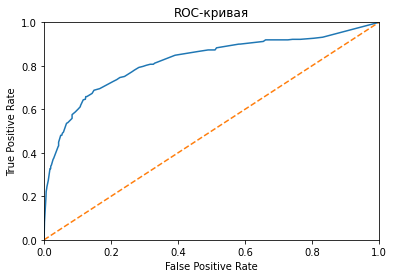

In [37]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

Протестируем следующую по метрике F1 модель - случайный лес. Гиперпараметры следующие:
* `max_depth`: 10, 
* `min_samples_leaf`: 1, 
* `min_samples_split`: 4,
* `n_estimators`: 100

In [29]:
%%time

model = RandomForestClassifier(
    random_state=987654,
    max_depth=10, 
    min_samples_leaf=1, 
    min_samples_split=4,
    n_estimators=100
)
model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_test)
f'Значение F1-меры: {f1_score(target_test, predictions)}'

CPU times: user 864 ms, sys: 3.94 ms, total: 868 ms
Wall time: 876 ms


'Значение F1-меры: 0.615219721329046'

В результате получено значение F1-меры равное 0,615. Это выше требуемого порога в 0,59.

## Исследование AUC-ROC 

Измерим значение метрики AUC-ROC нашей наилучшей модели на тестовой выборке.

In [30]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

f'Значение метрики auc-roc равно: {roc_auc_score(target_test, probabilities_one_test)}'

'Значение метрики auc-roc равно: 0.8557140665746279'

Это довольно большое значение площади (AUC) под кривой ROC. Построим график.

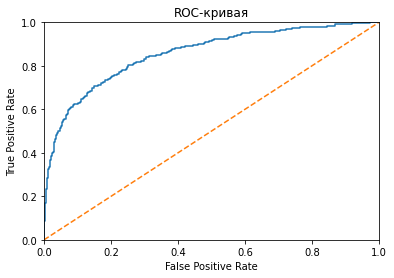

In [31]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

## Общий вывод 

В результате обработки данных и проверки нескольких техник борьбы с дисбалансом классов была обучена модель случайного леса с использованием техники upsampling и гиперпараметрами:
* `'max_depth'`: 10, 
* `'min_samples_leaf'`: 1, 
* `'min_samples_split'`: 4, 
* `'n_estimators'`: 100

Значение F1-меры данной модели на тестовой выборке составило 0,6150. Это выше необходимого порога в 0,59.
Значение метрики AUC-ROC данной модели на тестовой выборке составило 0,8557. Модель довольно хорошо справляется с правильной классификацией целевого признака.